In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

# 数据导入

In [3]:
import os

In [4]:
base_dir = './dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [5]:
transform = transforms.Compose([
    # 统一缩放到96 * 96
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    # 正则化
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
train_ds = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_ds = torchvision.datasets.ImageFolder(test_dir, transform=transform)

batch_size = 32
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size)

# 加载预训练好的模型

In [7]:
# 加载预训练好的模型
model = torchvision.models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Administrator/.cache\torch\hub\checkpoints\vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

# 查看模型（修改-->为我所用）

In [8]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
model.features.parameters()

<generator object Module.parameters at 0x00000234E572A5F0>

In [10]:
for param in model.features.parameters():
    param.requires_grad = False

In [11]:
# 修改原网络中的输出层的结构. 
model.classifier[-1].out_features = 4

另一种修改输出层的写法. 

model.classifier[-1] = torch.nn.Linear(model.classifier[-1], 4)

In [12]:
# 拷到gpu上
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# 配置网络

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [14]:
def fit(epoch, model, train_loader, test_loader):
    correct = 0
    total = 0
    running_loss = 0
    
    # 因为bn和dropout需要手动指定训练模式和推理模式
    model.train()
    for x, y in train_loader:
        # 把数据放到GPU上去. 
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
            
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
        
    # 测试过程
    test_correct = 0
    test_total = 0
    test_running_loss = 0
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    test_epoch_loss = test_running_loss / len(test_loader.dataset)
    test_epoch_acc = test_correct / test_total

    print('epoch: ', epoch,
         'loss: ', round(epoch_loss, 3),
         'accuracy: ', round(epoch_acc, 3),
         'test_loss: ', round(test_epoch_loss, 3),
         'test_accuracy: ', round(test_epoch_acc, 3))
    return epoch_loss, epoch_acc, test_epoch_loss, test_epoch_acc

In [15]:
epochs = 10
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for epoch in range(epochs):
    epoch_loss, epoch_acc, test_epoch_loss, test_epoch_acc = fit(epoch, model, train_dl, test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    
    test_loss.append(test_epoch_loss)
    test_acc.append(test_epoch_acc)

epoch:  0 loss:  0.055 accuracy:  0.763 test_loss:  0.019 test_accuracy:  0.916
epoch:  1 loss:  0.026 accuracy:  0.902 test_loss:  0.013 test_accuracy:  0.942
epoch:  2 loss:  0.009 accuracy:  0.953 test_loss:  0.013 test_accuracy:  0.951
epoch:  3 loss:  0.007 accuracy:  0.968 test_loss:  0.033 test_accuracy:  0.92
epoch:  4 loss:  0.011 accuracy:  0.963 test_loss:  0.035 test_accuracy:  0.911
epoch:  5 loss:  0.014 accuracy:  0.959 test_loss:  0.029 test_accuracy:  0.929
epoch:  6 loss:  0.012 accuracy:  0.975 test_loss:  0.079 test_accuracy:  0.916
epoch:  7 loss:  0.01 accuracy:  0.979 test_loss:  0.033 test_accuracy:  0.956
epoch:  8 loss:  0.013 accuracy:  0.968 test_loss:  0.138 test_accuracy:  0.893
epoch:  9 loss:  0.032 accuracy:  0.96 test_loss:  0.117 test_accuracy:  0.929


In [16]:
model.parameters()

<generator object Module.parameters at 0x00000234E6885890>

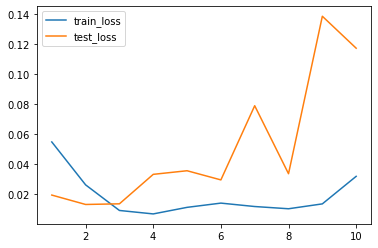

In [17]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()

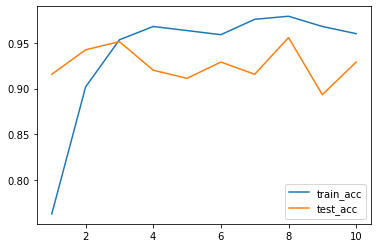

In [18]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()

# 模型保存

state_dict, 是一个字典, 保存了训练模型.

In [19]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
model.state_dict()

OrderedDict([('features.0.weight',
              tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
                        [-5.8312e-01,  3.5655e-01,  7.6566e-01],
                        [-6.9022e-01, -4.8019e-02,  4.8409e-01]],
              
                       [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
                        [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
                        [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],
              
                       [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
                        [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
                        [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],
              
              
                      [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
                        [-4.2805e-01, -2.4349e-01,  2.4628e-01],
                        [-2.5066e-01,  1.4177e-01, -5.4864e-03]],
              
                       [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
                        [-8.4127e-01, -3

In [21]:
# 保存参数
path = './vgg16.pth'
torch.save(model.state_dict(), path)